In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

> Początek początku - wczytujemy dane

In [4]:
XY = np.loadtxt('dane.data')
print(XY[0])
print(XY.shape)

[-10.   -3.    2.   -1.   47.   -1.   17.  244.6]
(1999, 8)


> Teraz możemy sobie popatrzeć na dane

In [5]:
df = pd.DataFrame(data=XY, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])

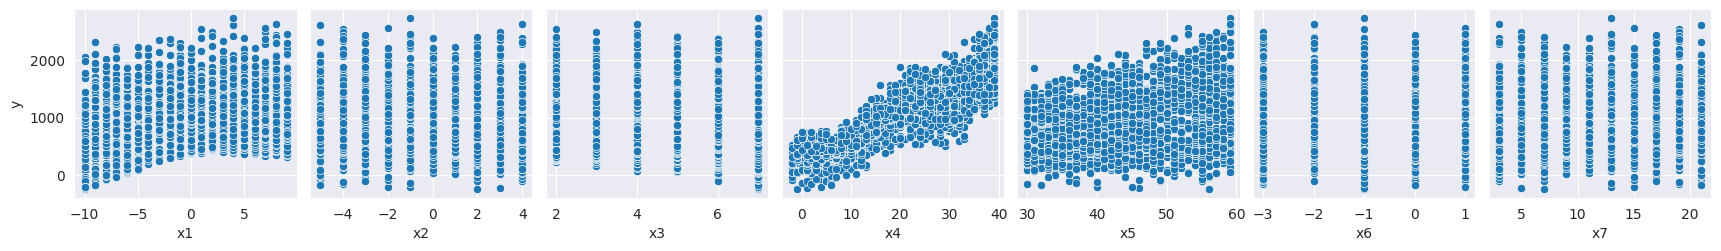

In [6]:
grid = sns.pairplot(df, x_vars=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], y_vars=['y'])

<Axes: >

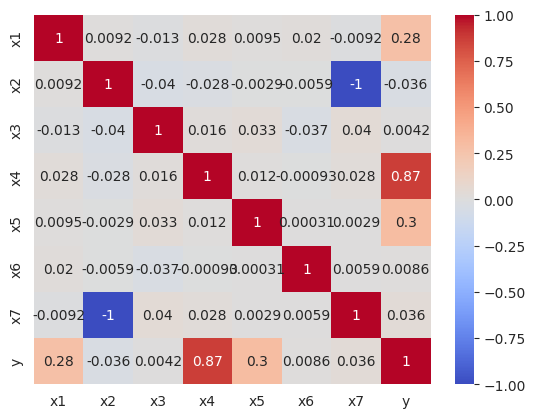

In [7]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

> Coś tam widać \
> Ale czy to nas obchodzi? Na razie nie. Lecimy z najbardziej basic regresją

In [14]:
def divide_dataset(data, validation=False, shuffle=True):
    if shuffle:
        np.random.shuffle(data)
    train_ratio = 0.6 if validation else 0.8
    val_ratio = 0.2 if validation else 0
    # test_ratio - the rest
    n = len(data)
    n1 = int(n * train_ratio)
    n2 = int(n * val_ratio)
    return data[:n1], data[n1:n1+n2], data[n1+n2:]

def split_data(data):
    X = data[:, :-1]
    y = data[:, -1].reshape((-1, 1))
    return X, y

def basic_linear_regression(X, y):
    X = np.c_[np.ones(X.shape[0]), X]
    theta = np.linalg.pinv(X.T @ X) @ X.T @ y # OLS
    return theta

In [222]:
T = 10 # numer of iterations
divided_sets = []
for i in range(T):
    divided_sets.append(divide_dataset(XY.copy(), validation=True, shuffle=True))
print(len(divided_sets))

10


In [223]:
def run_basic_linear_regression(divided_sets):
    t = len(divided_sets)
    total_error = 0
    total_theta = np.zeros((divided_sets[0][0].shape[1], 1))

    for train, _, test in divided_sets:
        X_train, y_train = split_data(train)
        X_test, y_test = split_data(test)

        theta = basic_linear_regression(X_train, y_train)
        total_theta += theta

        y_pred = np.c_[np.ones(X_test.shape[0]), X_test] @ theta

        error = np.mean((y_test - y_pred) ** 2) * 0.5
        total_error += error

    avg_error = total_error / t
    avg_theta = total_theta / t

    return avg_theta, avg_error

> Zobaczmy co nam wyjdzie

In [224]:
theta, error = run_basic_linear_regression(divided_sets)
print(f"Theta: {theta}")
print(f"Error: {error}")

Theta: [[-20.72003895]
 [ 23.19457926]
 [-91.83139758]
 [ -4.68053699]
 [ 38.06527913]
 [ 18.2370137 ]
 [  0.20081023]
 [-44.25763332]]
Error: 14509.446198318687


> Ten error jest przerażający, ale to przez OLS. \
> Spróbujmy przeskalować dane.

> EDIT1: Zanim skalowanie, jeszcze gradient policzmy: GD i SGD

> EDIT2: Nie działa mi GD, więc sprawdzam czy to wina braku normalizacji danych

In [216]:
def finite_difference_gradient(X, y, theta, epsilon):
    grad = np.zeros_like(theta)
    for i in range(len(theta)):
        theta_plus = theta.copy()
        theta_minus = theta.copy()
        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon

        y_pred_plus = X @ theta_plus
        y_pred_minus = X @ theta_minus

        loss_plus = np.mean((y - y_pred_plus) ** 2) * 0.5
        loss_minus = np.mean((y - y_pred_minus) ** 2) * 0.5

        grad[i] = (loss_plus - loss_minus) / (2 * epsilon)
    return grad

def GD_linear_regression_finite_diff(X, y, alpha, k, epsilon):
    X = np.c_[np.ones(X.shape[0]), X]
    theta = np.zeros((X.shape[1], 1))
    for i in range(k):
        grad = finite_difference_gradient(X, y, theta, epsilon)
        theta -= alpha * grad
    return theta

def run_GD_fd_linear_regression(divided_sets, alpha=0.0001, k=3000, epsilon=1e-5):
    t = len(divided_sets)
    total_error = 0
    total_theta = np.zeros((divided_sets[0][0].shape[1], 1))

    for train, val, test in divided_sets:
        X_train, y_train = split_data(train)
        X_val, y_val = split_data(val)
        X_test, y_test = split_data(test)

        theta = GD_linear_regression_finite_diff(X_train, y_train, alpha, k, epsilon)
        total_theta += theta

        y_pred = np.c_[np.ones(X_test.shape[0]), X_test] @ theta

        error = np.mean((y_test - y_pred) ** 2) * 0.5
        total_error += error

    avg_error = total_error / t
    avg_theta = total_theta / t

    return avg_theta, avg_error

In [225]:
theta, error = run_GD_fd_linear_regression(divided_sets)
print(f"Theta: {theta}")
print(f"Error: {error}")

Theta: [[ -3.88146732]
 [ 23.49878787]
 [-16.39712189]
 [-13.10969877]
 [ 36.70932052]
 [ 11.21270577]
 [  2.94439267]
 [ -9.9018969 ]]
Error: 16488.218031729408


> WOW to zbiega, czyli nie umiem liczyć gradientu :( \
> Ale dużo się różni od optymalnego rozwiązania. Podejrzewam związek z korelacją.

In [227]:
def GD_linear_regression(X, y, alpha, k):
    X = np.c_[np.ones(X.shape[0]), X]
    theta = np.zeros((X.shape[1], 1))
    for i in range(k):
        y_pred = X @ theta
        er = y_pred - y
        gd = np.mean(X * er, axis=0).reshape((-1, 1))
        theta -= alpha * gd
    return theta

def run_GD_linear_regression(divided_sets, alpha=0.0001, k=3000):
    t = len(divided_sets)
    total_error = 0
    total_theta = np.zeros((divided_sets[0][0].shape[1], 1))

    for train, val, test in divided_sets:
        X_train, y_train = split_data(train)
        X_val, y_val = split_data(val)
        X_test, y_test = split_data(test)

        theta = GD_linear_regression(X_train, y_train, alpha, k)
        total_theta += theta

        y_pred = np.c_[np.ones(X_test.shape[0]), X_test] @ theta

        error = np.mean((y_test - y_pred) ** 2) * 0.5
        total_error += error

    avg_error = total_error / t
    avg_theta = total_theta / t

    return avg_theta, avg_error

In [228]:
theta, error = run_GD_linear_regression(divided_sets)
print(f"Theta: {theta}")
print(f"Error: {error}")

Theta: [[ -3.88146734]
 [ 23.49878786]
 [-16.39712189]
 [-13.10969876]
 [ 36.70932052]
 [ 11.21270577]
 [  2.94439267]
 [ -9.9018969 ]]
Error: 16488.218031564546


> EDIT3: wszystko działa jak się da alpha/m z sumą :)

> TODO: testowac na wspolnych setach danych z takim samym seedem \
> EDIT4: DONE


> To teraz czas na SGD

In [235]:
def SGD_linear_regression(X, y, alpha, k, batch_size):
    X = np.c_[np.ones(X.shape[0]), X]
    theta = np.zeros((X.shape[1], 1))
    num_batches = max(X.shape[0] // batch_size, 1)

    for i in range(k):
        perm = np.random.permutation(X.shape[0])
        X_perm = X[perm]
        y_perm = y[perm]
        for (X_batch, y_batch) in zip(
                np.array_split(X_perm, num_batches),
                np.array_split(y_perm, num_batches)):
            y_pred = X_batch @ theta
            er = y_pred - y_batch
            gd = np.mean(X_batch * er, axis=0).reshape((-1, 1))
            theta -= alpha * gd
    return theta

def run_SGD_linear_regression(divided_sets, alpha=0.0001, k=3000, batch_size=32):
    t = len(divided_sets)
    total_error = 0
    total_theta = np.zeros((divided_sets[0][0].shape[1], 1))

    for train, val, test in divided_sets:
        X_train, y_train = split_data(train)
        X_val, y_val = split_data(val)
        X_test, y_test = split_data(test)

        theta = SGD_linear_regression(X_train, y_train, alpha, k, batch_size)
        total_theta += theta

        y_pred = np.c_[np.ones(X_test.shape[0]), X_test] @ theta

        error = np.mean((y_test - y_pred) ** 2) * 0.5
        total_error += error

    avg_error = total_error / t
    avg_theta = total_theta / t

    return avg_theta, avg_error

In [236]:
theta, error = run_SGD_linear_regression(divided_sets)
print(f"Theta: {theta}")
print(f"Error: {error}")

Theta: [[-20.70201486]
 [ 23.19521324]
 [-91.75862597]
 [ -4.69527819]
 [ 38.08115052]
 [ 18.32793144]
 [  0.1992544 ]
 [-44.20491153]]
Error: 14589.512333774133


> WOWOWO SGD jest świetny, prawie minimum

> Dobra to teraz wykresiki